In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import DualwormFunctions as dw
import Observables as obs

%load_ext line_profiler
%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import yep

In [3]:
nst = 1024
nsm = 64
nips = 4;
nrps = 4;
nb = 32
measperiod = 4;
nt = 32
nh = 2
ncores = 4
nmaxiter = 1
L = 12
J1 = 1
J2 = 0
h = 0
measupdate =True
p = 3 # when v = v1, p = htip/J. Values to try: 0, 2, 4
version = 1
save = True
if not measupdate:
    p= 0

stroutput = "PSIMeasupdate_SaveBeforeUpdate_v1_J1={0}_J2={3}_L={1}_p={2}_first".format(J1,L,p,J2)

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = 0.0,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 GS''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = False, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = 'JustSomeJ1-1J21J31Test2_step1_folder',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = measupdate, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--measupdatev', type = int, default = version,
                       help = '''select the version of measupdate''')
    parser.add_argument('--measupdatesave', default = save, action = 'store_true',
                       help = '''activate to cancel measurement update before continuing''')
    parser.add_argument('--p', type = float, default = p, 
                       help = '''version 0: prob of the measuring tip flipping the spin (number between 0 and 1)
                       \n version 1: htip/J (try 0, 2, 4)''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--notfullssfupdate', default = False, action = 'store_true',
                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')
    parser.add_argument('--alternate', default = True, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.01,60],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = False, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = True, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = True, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--correlations', default = True, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--all_correlations', default = False, action = 'store_true',
                        help = '''activate if you want to save the correlations for all non-equivalent
                        pairs of sites. Otherwise, will save central correlations.''')
    parser.add_argument('--firstcorrelations', default = True, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    parser.add_argument('--verbose',default = False, action = 'store_true',
                        help = 'activate verbosity')
    args = parser.parse_args()
    return args



In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
#%%prun -s  -T prun0
#yep.start(stroutput+'.log')
%lprun -f dw.mcs_swaps [meanstat, swapst, swapsh, failedupdatesth, failedupdates] = callRunBasis()
#yep.stop()

-------------------Initialisation--------------------
./PSIMeasupdate_SaveBeforeUpdate_v1_J1=1_J2=0_L=12_p=3_first_folder/backup.hkl
Lattice side size:  12
J1  1
J2  0
J3  0.0
J3st  0.0
Couplings extracted
Hamiltonian expression (without field) computed
alternating ssf and dw update
Number of temperatures:  32
Temperatures: [1.00000000e-02 1.32396300e-02 1.75287801e-02 2.32074562e-02
 3.07258133e-02 4.06798398e-02 5.38586025e-02 7.13067968e-02
 9.44075602e-02 1.24992116e-01 1.65484937e-01 2.19095932e-01
 2.90074907e-01 3.84048443e-01 5.08465926e-01 6.73190071e-01
 8.91278743e-01 1.18002007e+00 1.56230291e+00 2.06843124e+00
 2.73852642e+00 3.62570765e+00 4.80030276e+00 6.35542322e+00
 8.41434516e+00 1.11402816e+01 1.47493206e+01 1.95275547e+01
 2.58537598e+01 3.42294213e+01 4.53184872e+01 6.00000000e+01]
Number of magnetic fields:  1
Magnetic fields:  [0.]
Fully random initialisation =  True
Identical initialisation =  False
Magnetisation initialisation =  False
Minimal energy index:  0

States Checked
Job done


In [7]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername + results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [8]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh,
 stat_hfields, hfields_plots, listfunctions, sref, idswalker] =\
af.LoadParameters(foldername, filenamelist)

[-0.66666667]


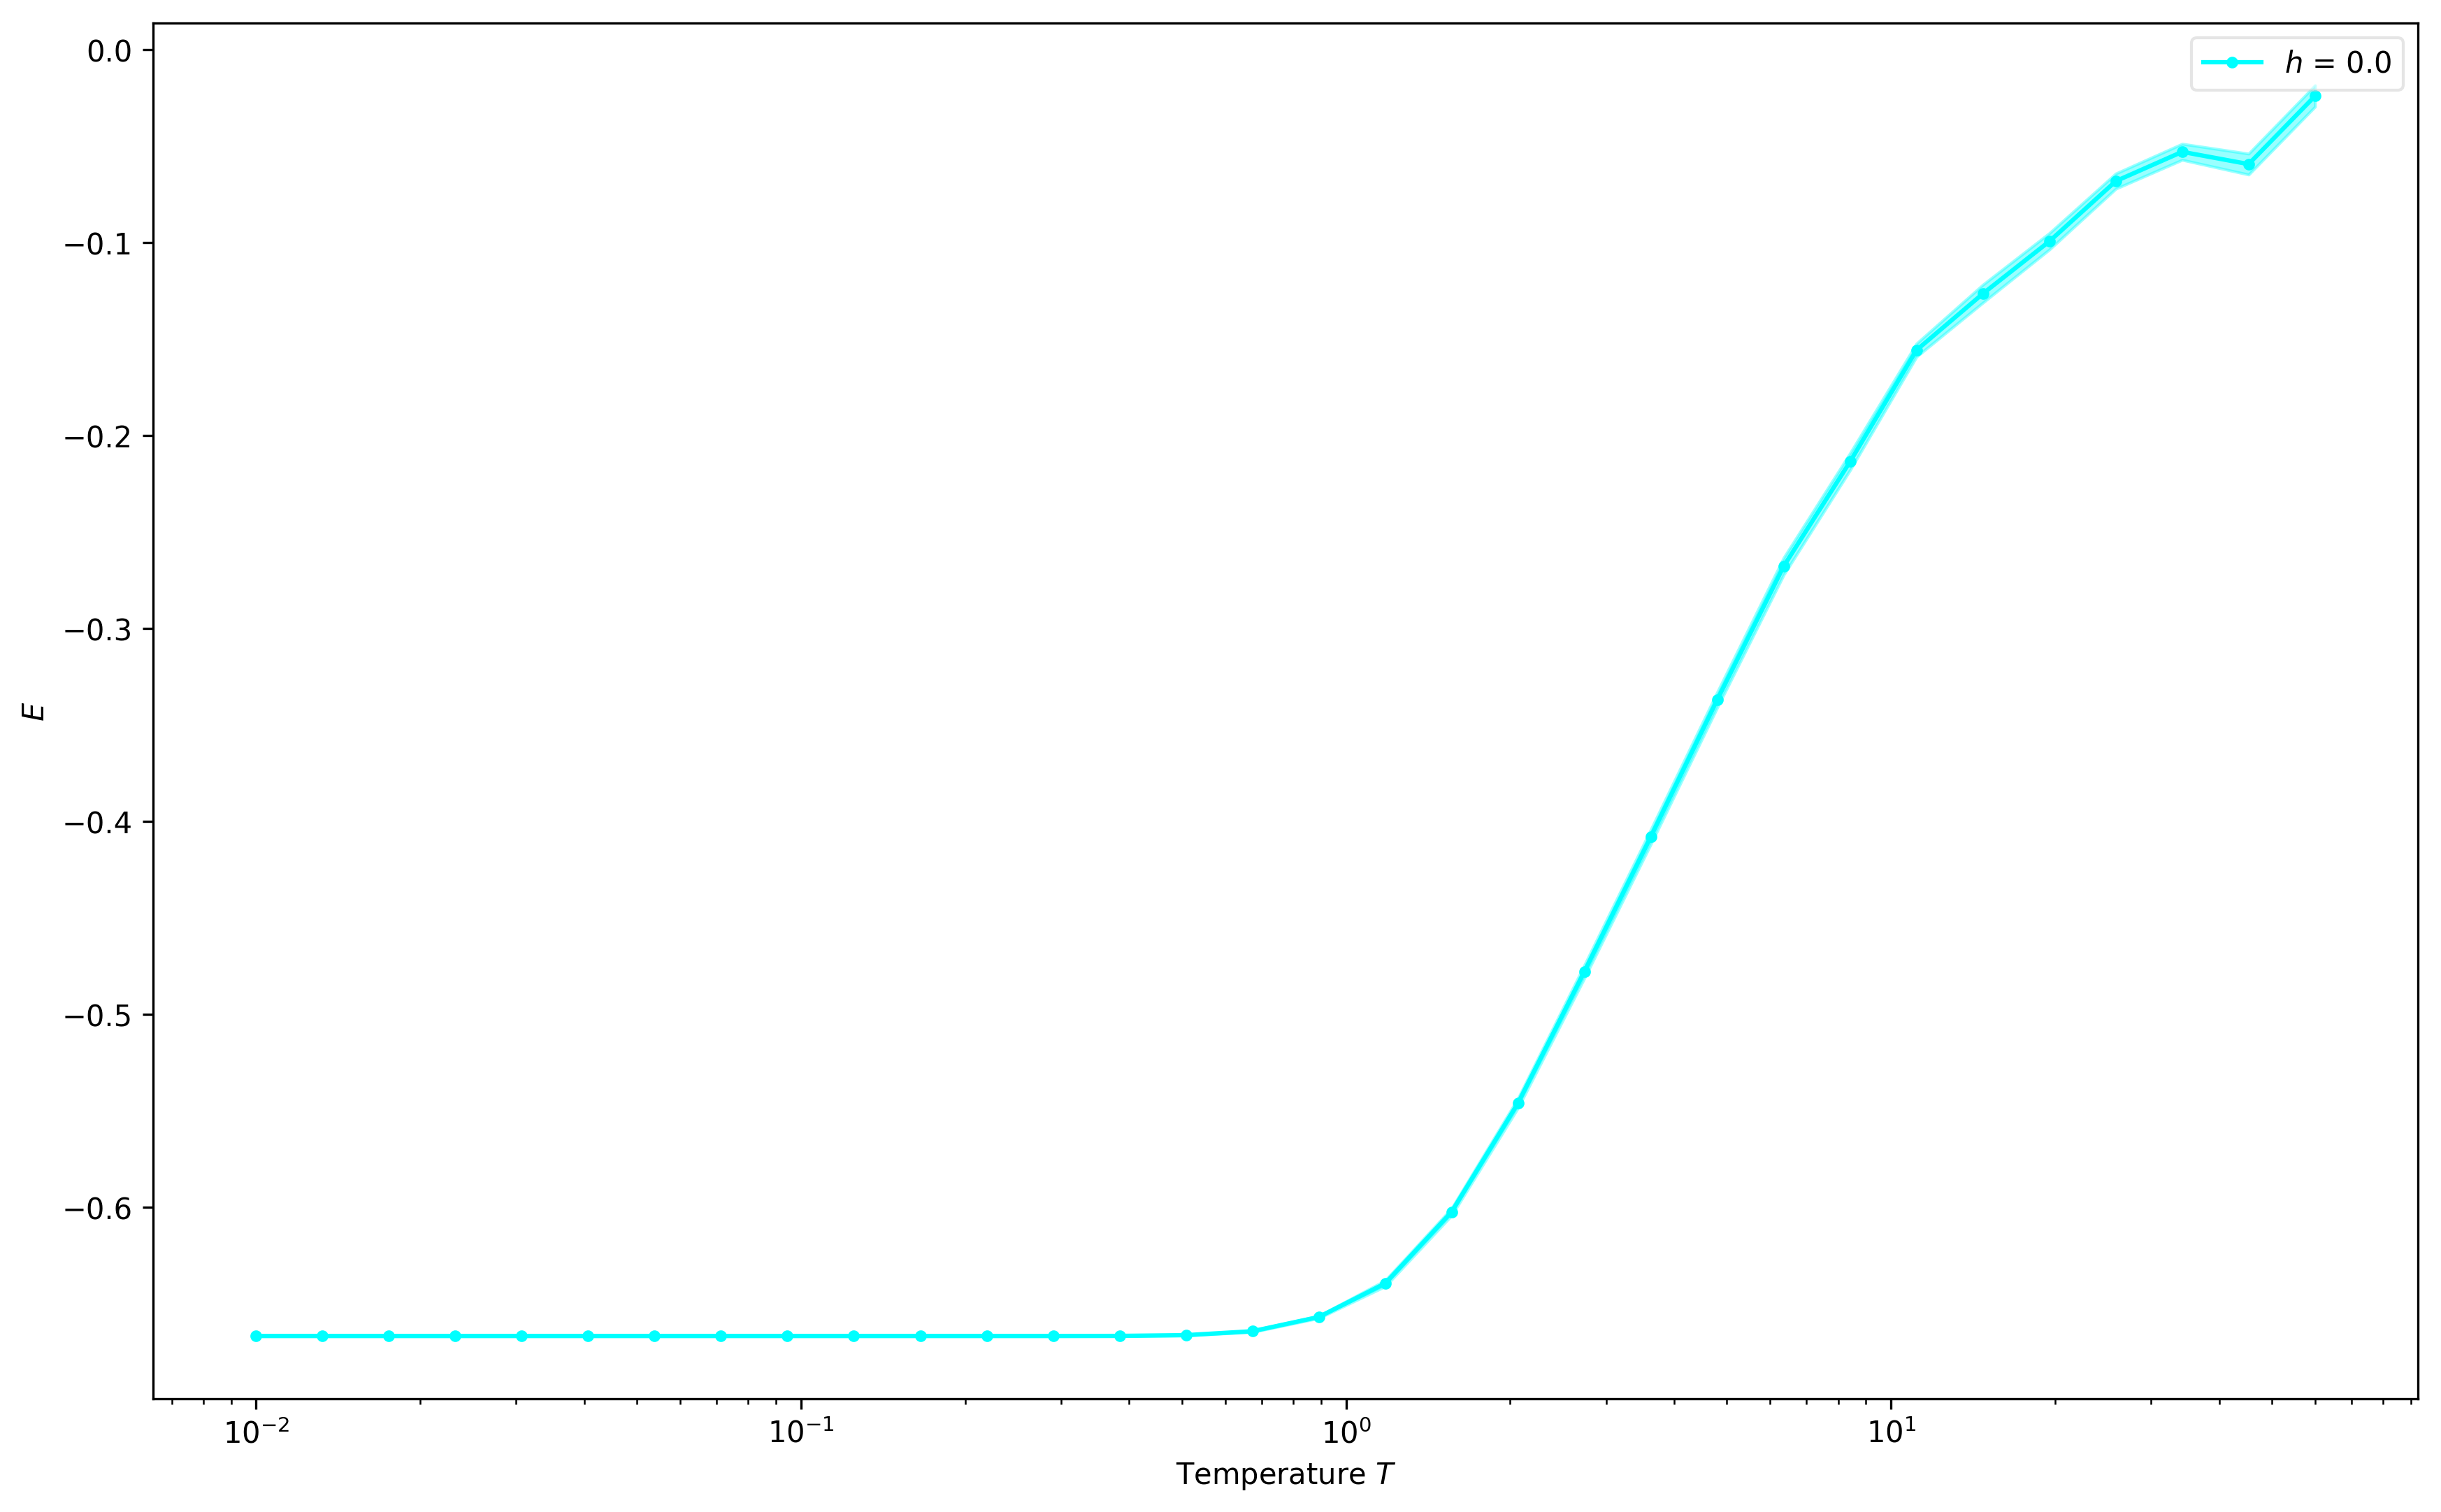

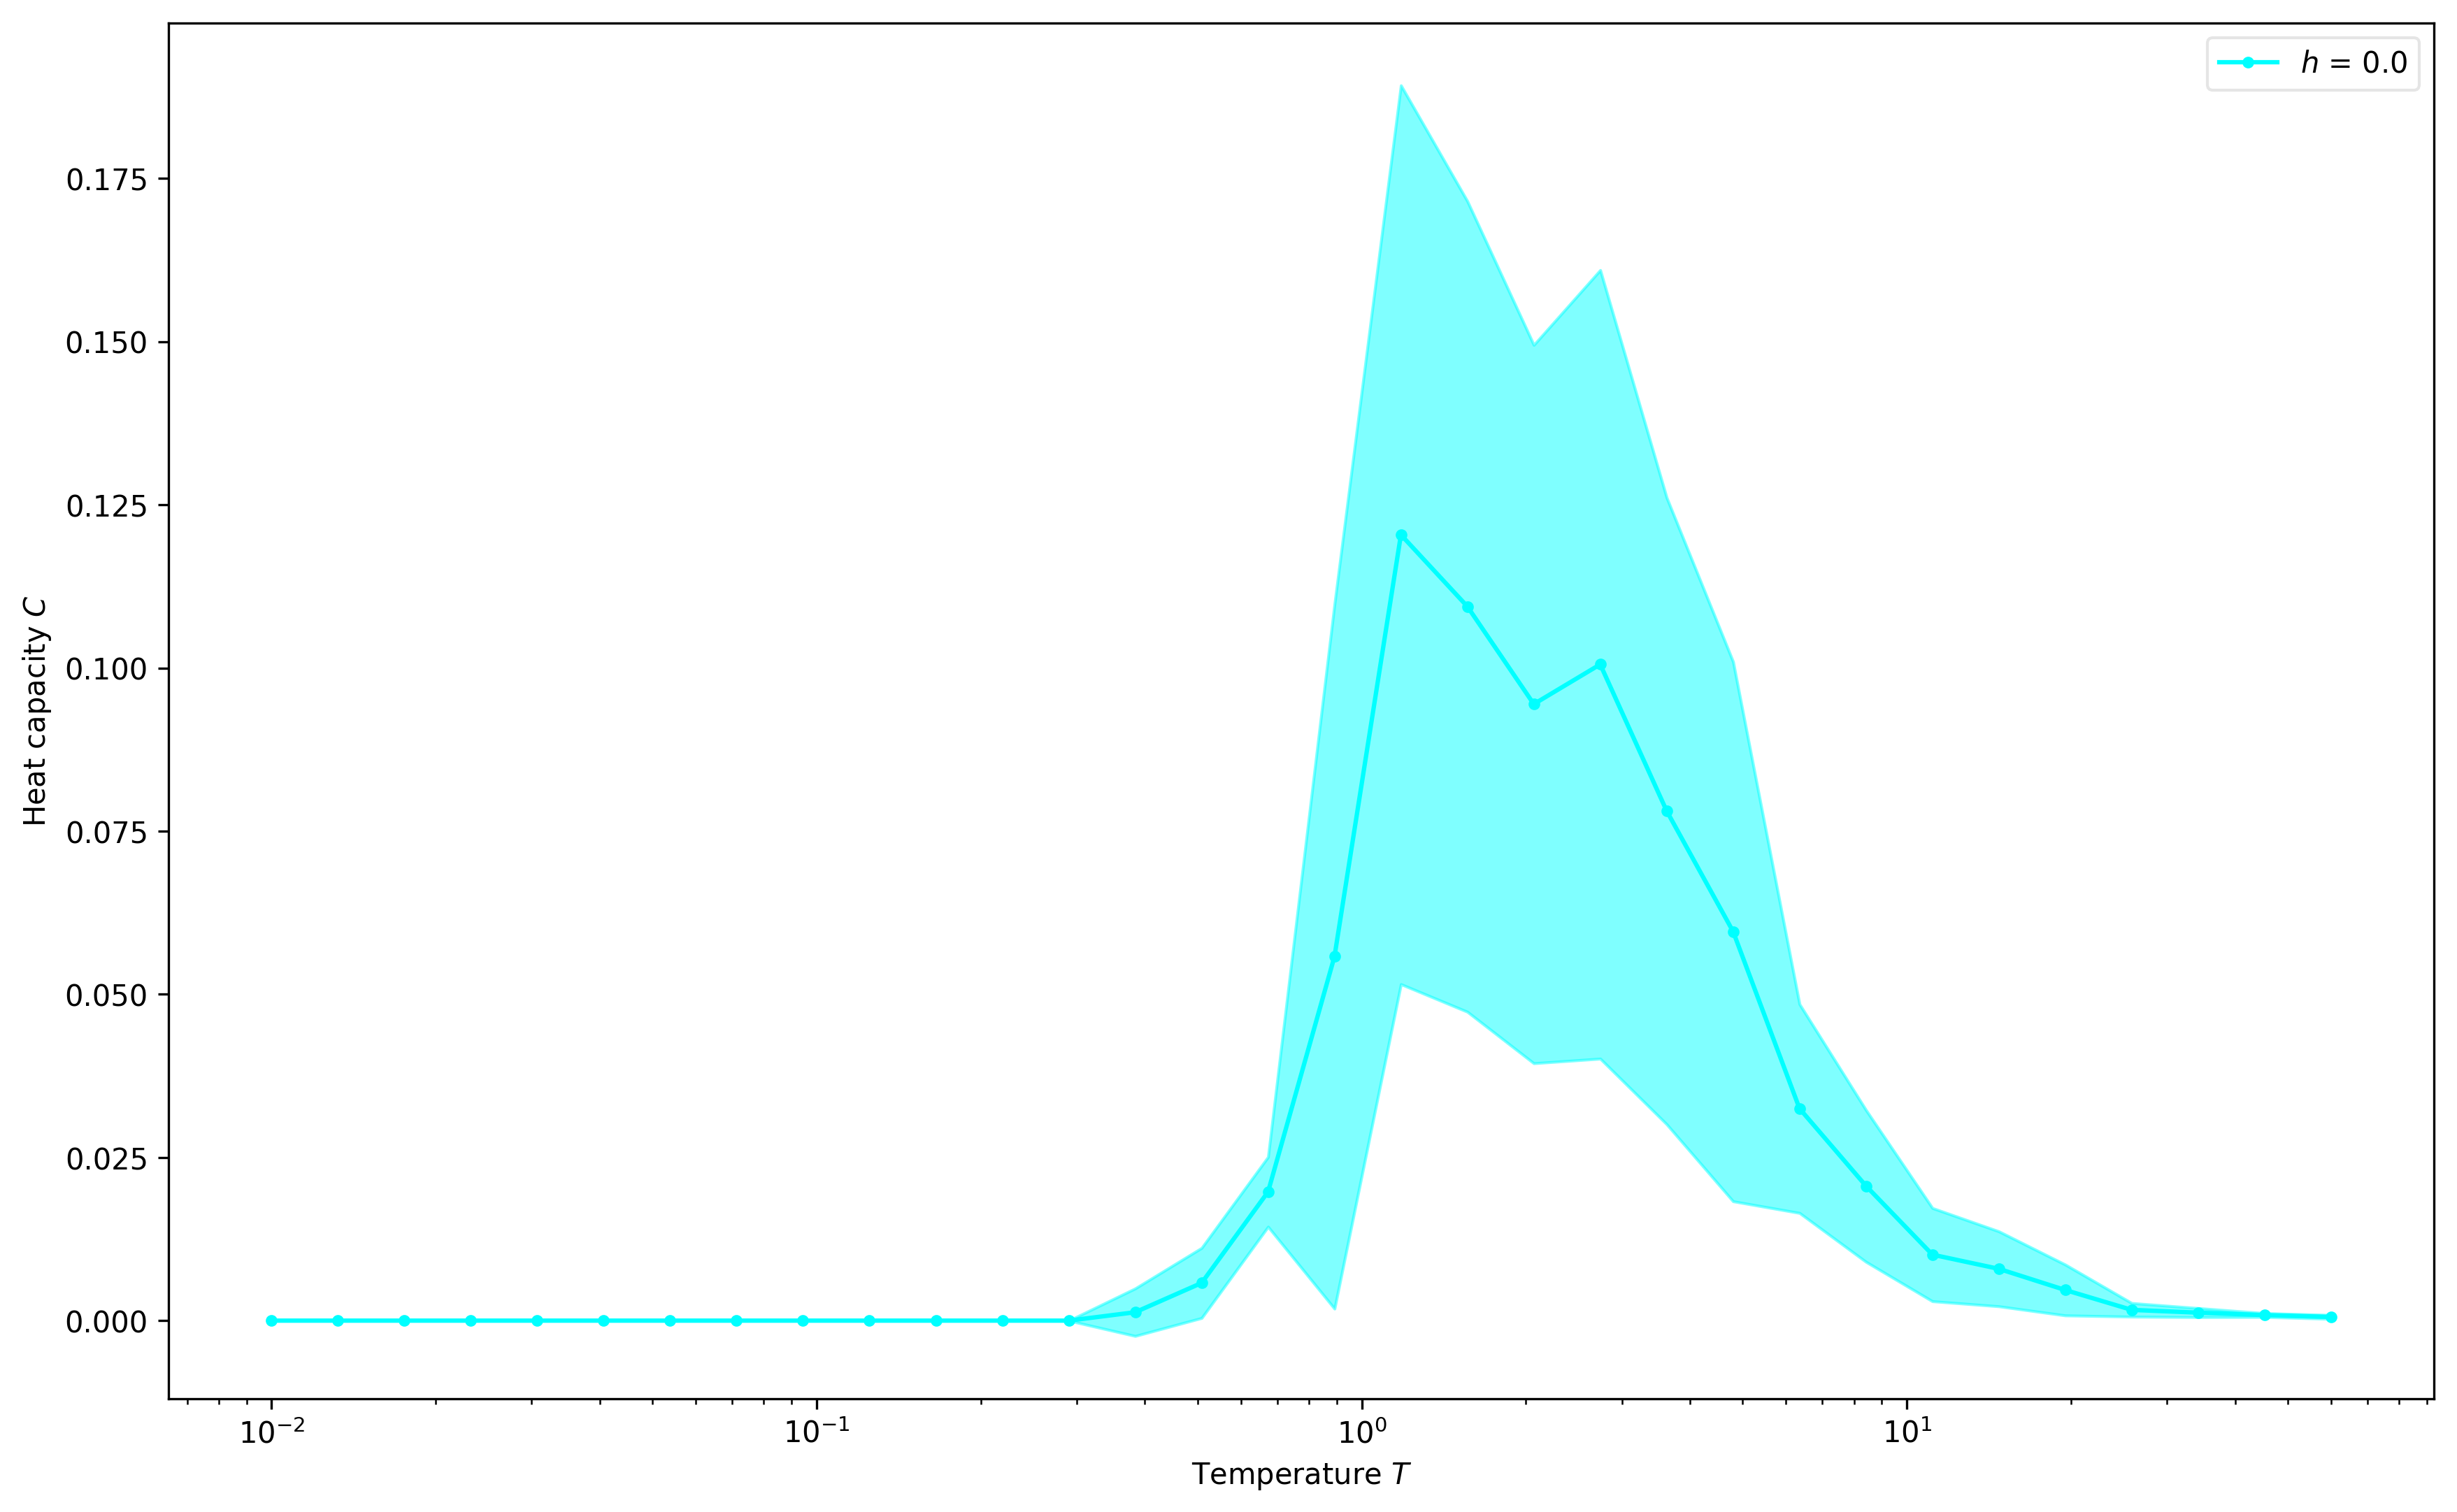

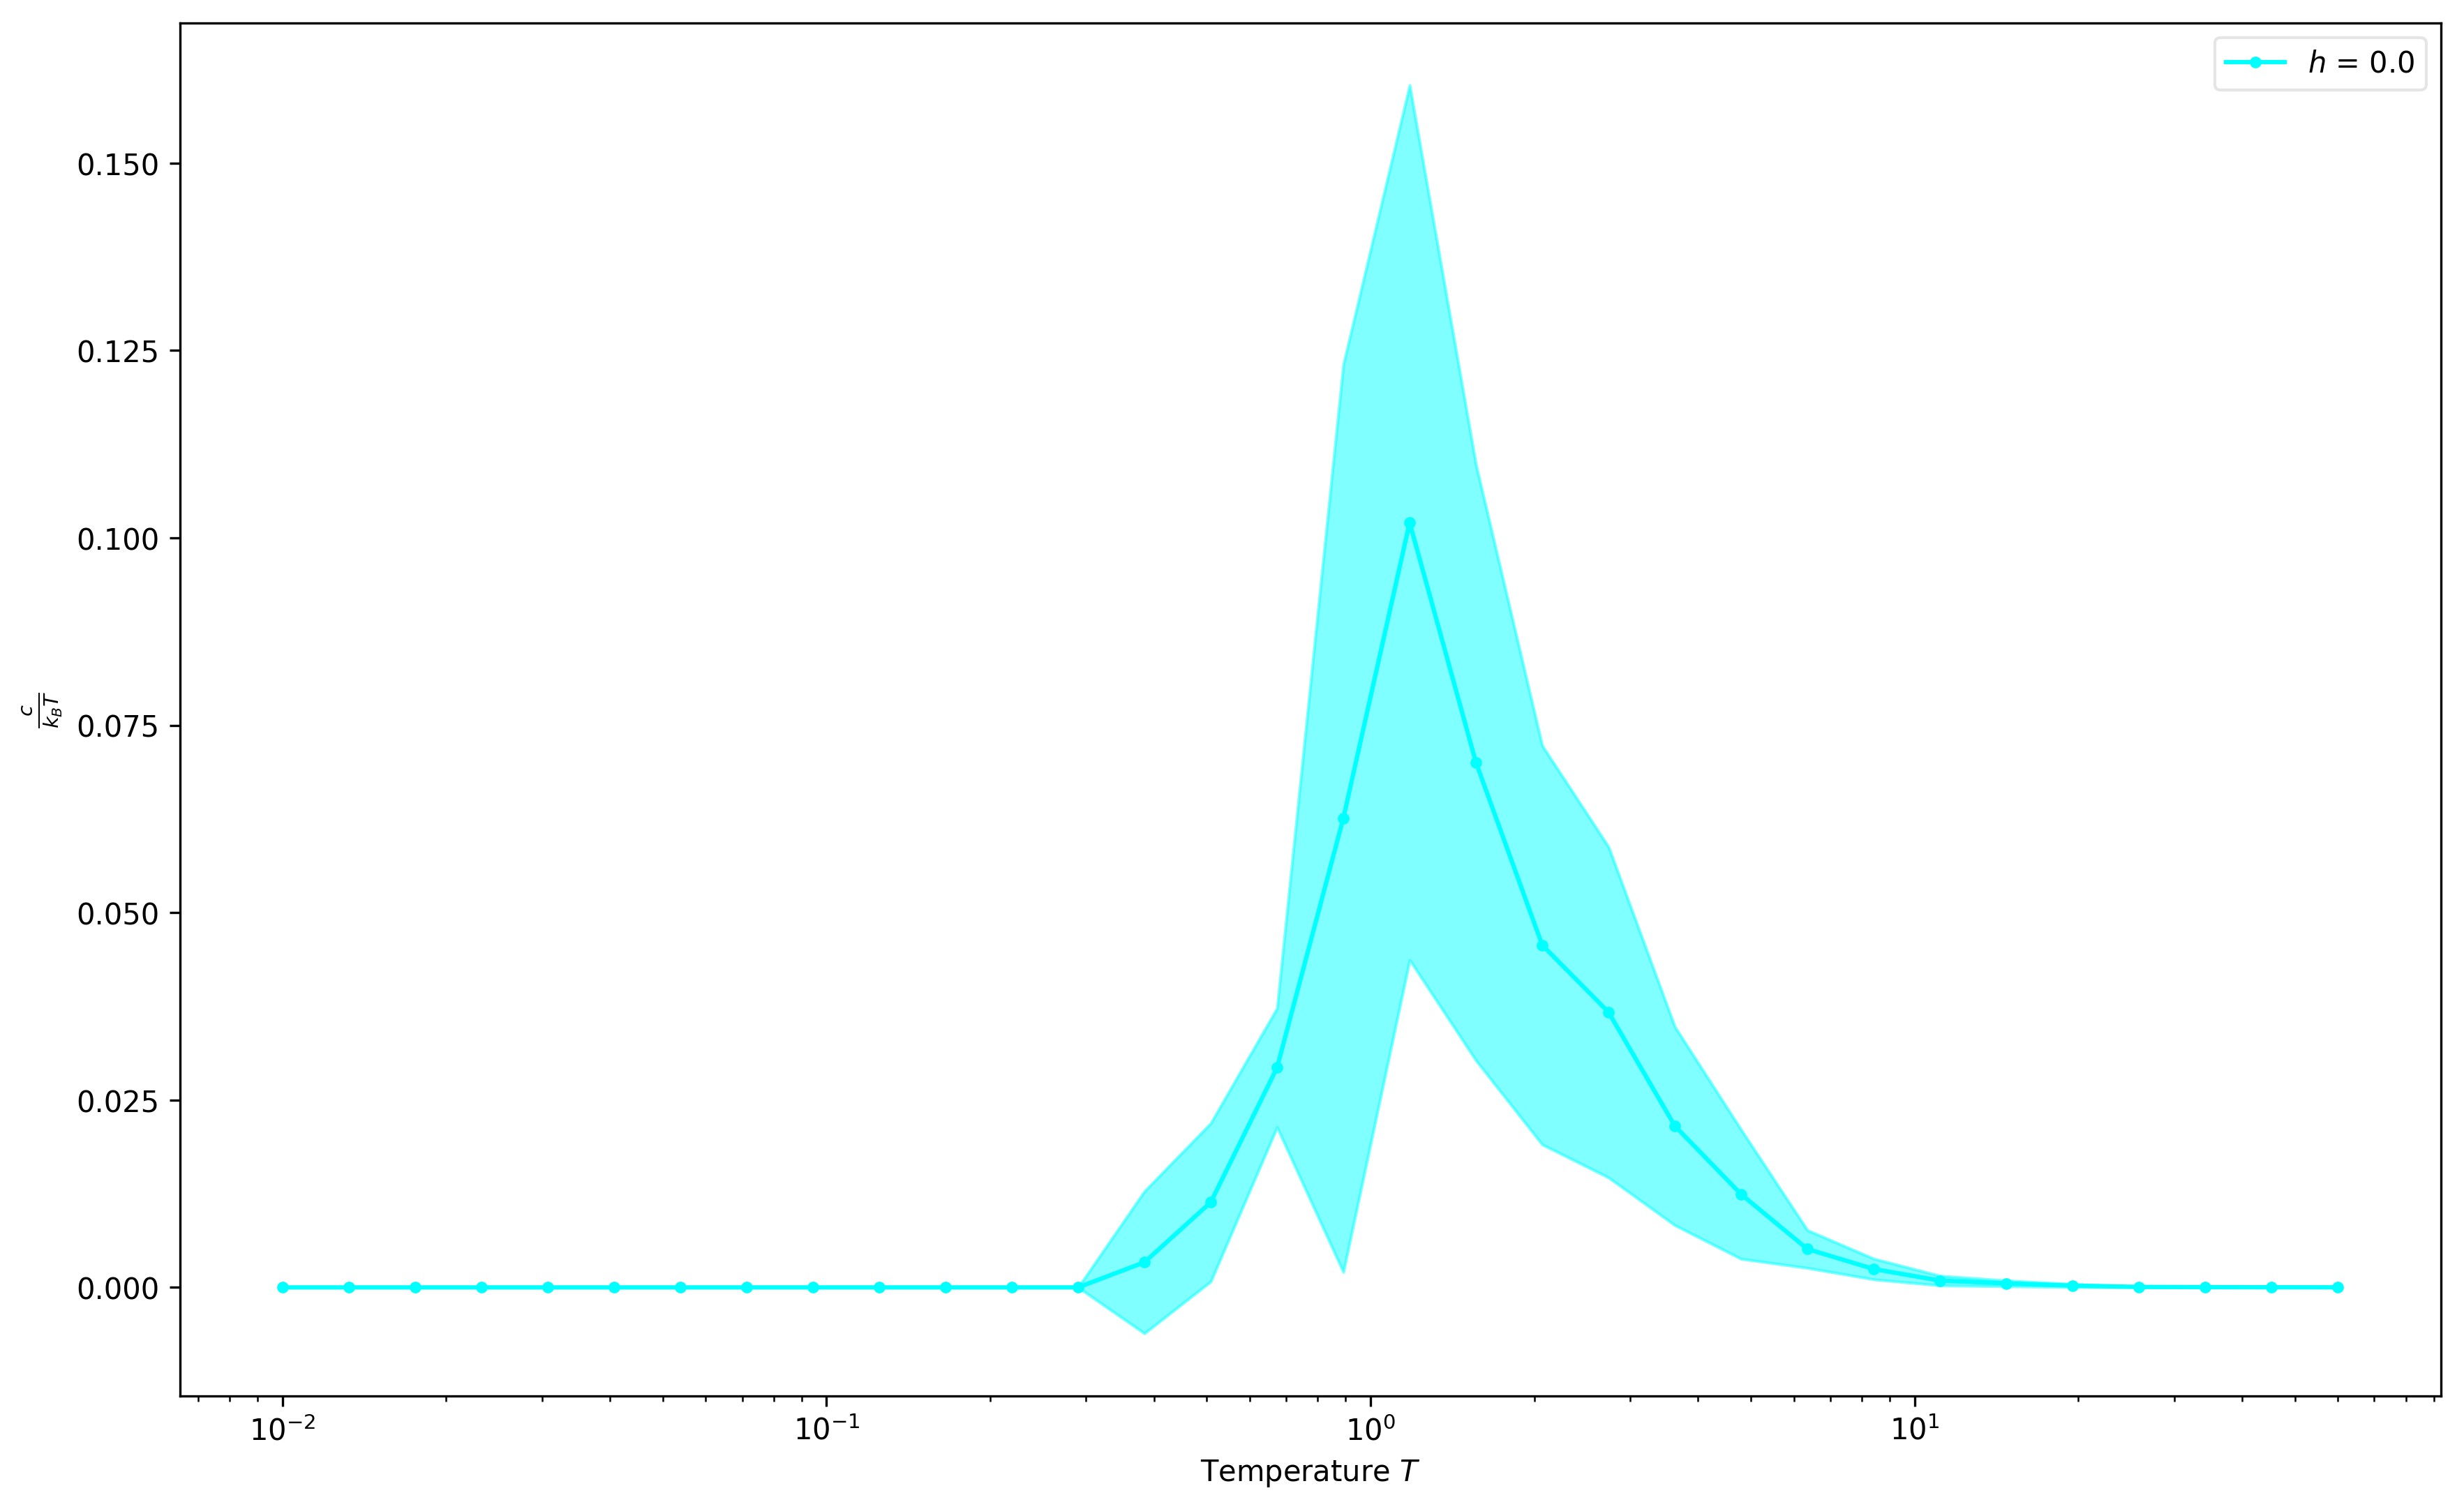

In [9]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsE(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanE, t_h_MeanEsq, t_h_varMeanE,
                t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, **kw)
plt.show()

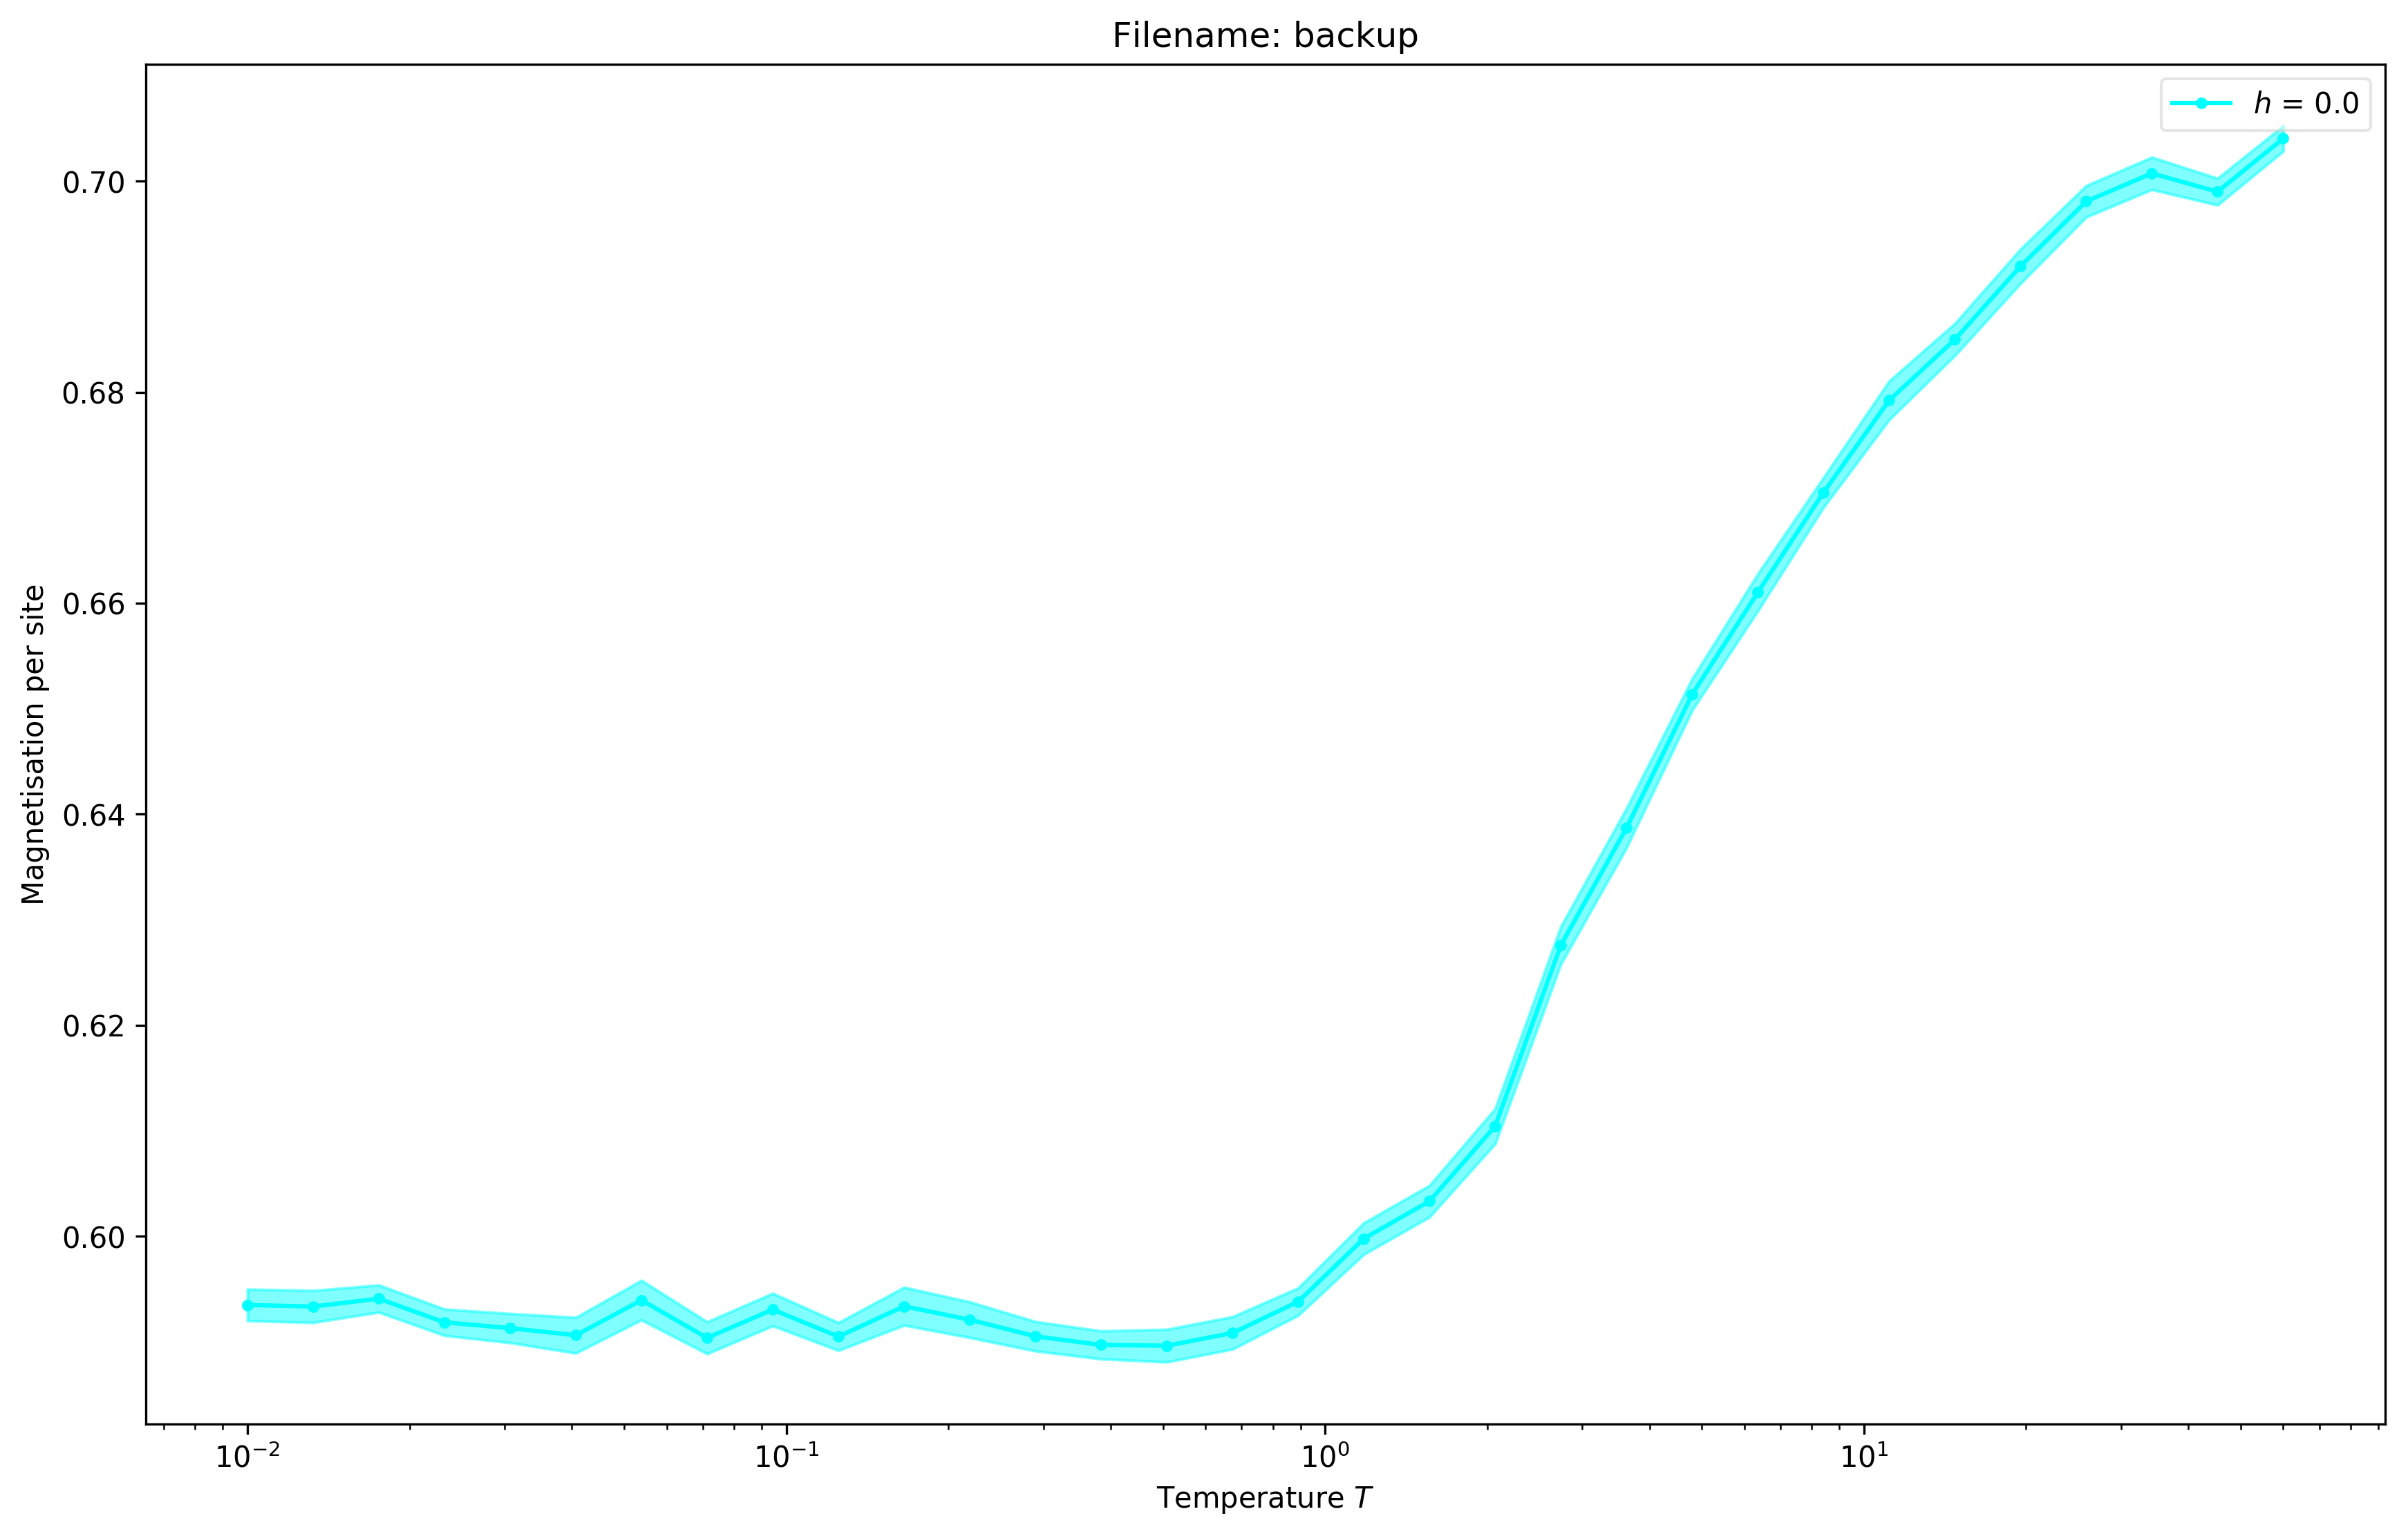

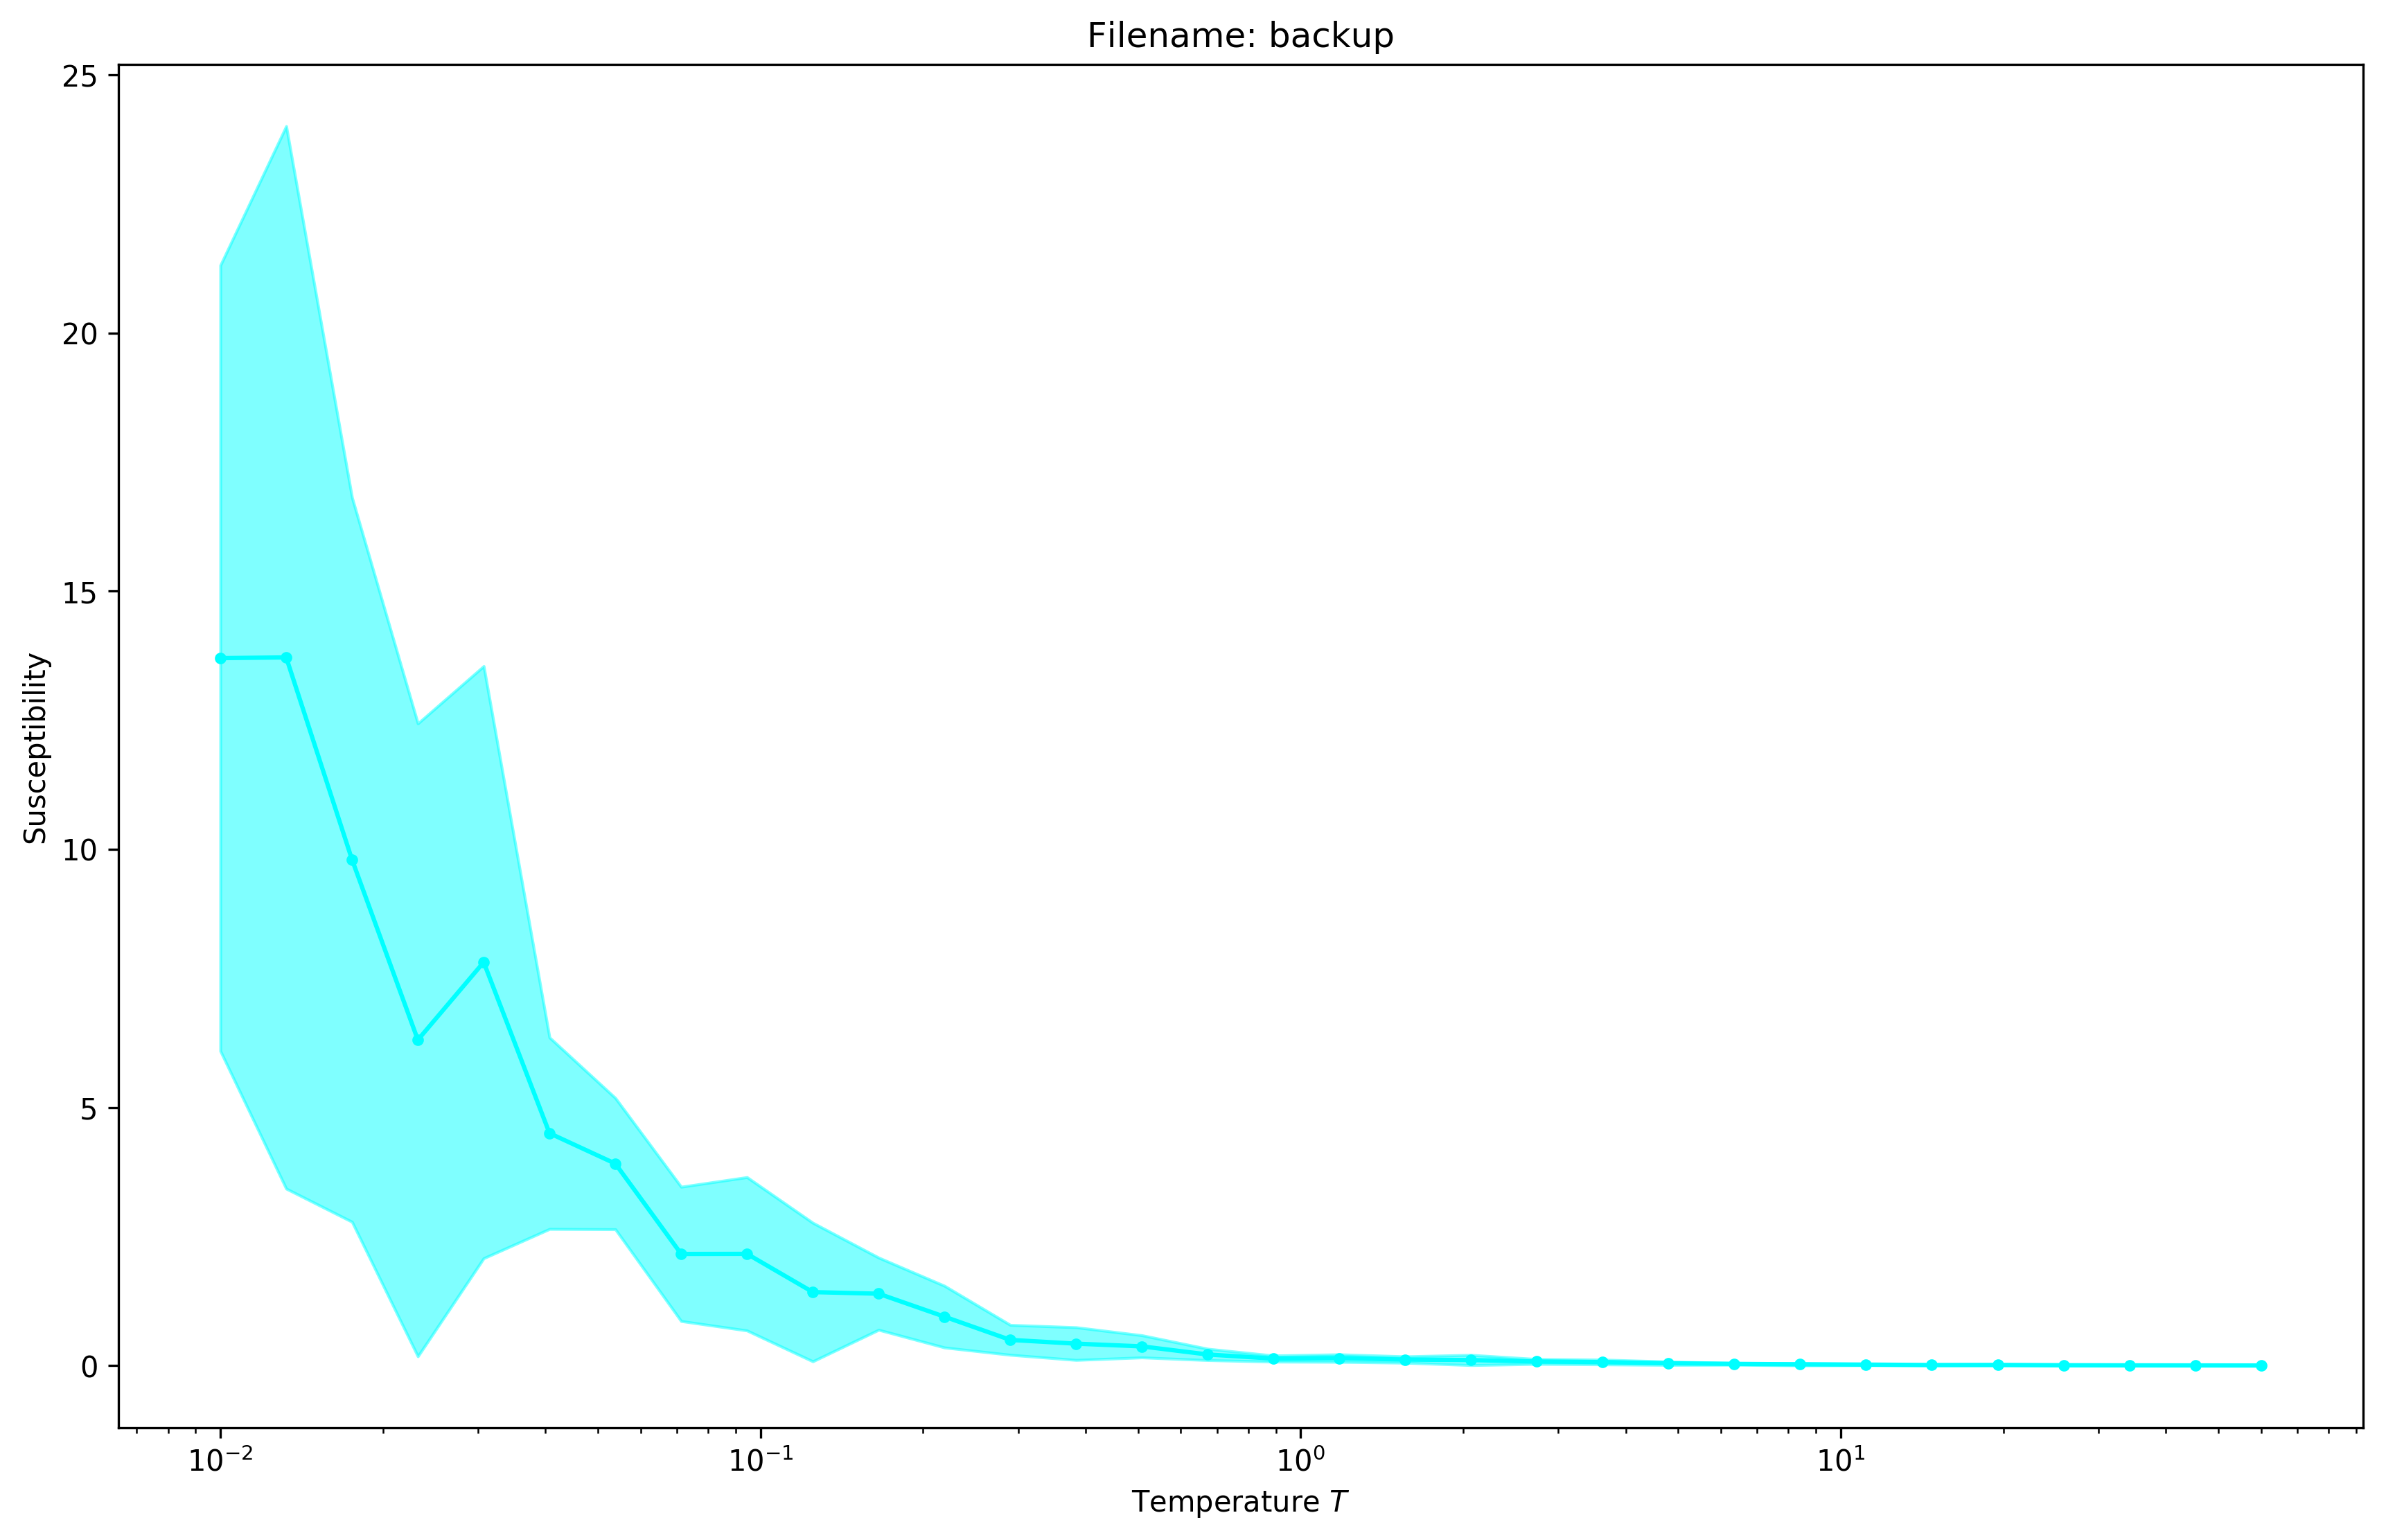

In [10]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanM, t_h_MeanMsq, t_h_varMeanM, t_h_varMeanMsq, Chi, ErrChi] = \
 af.LoadMagnetisation(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsM(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanM, t_h_MeanMsq, t_h_varMeanM,
                t_h_varMeanMsq, Chi, ErrChi, J1, J2, J3, J4, **kw)
plt.show()

In [11]:
import importlib
importlib.reload(af)

<module 'AnalysisFunctions' from '/home/jeanne/Documents/Codes/Codes_DipolarIsingModel/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py'>

In [12]:
t_h_MeanFc, t_h_varMeanFc, t_h_MeanSi, t_h_varMeanSi= \
 af.LoadFirstCorrelations(foldername, filenamelist, listfunctions, sref, stat_temps[0:4], stat_hfields, nb, **kw)


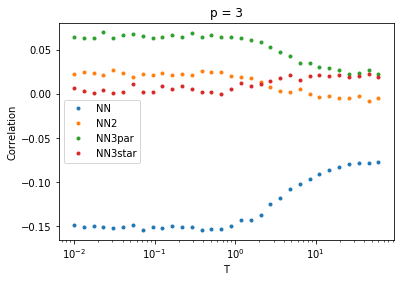

In [13]:
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,0],'.',label = 'NN')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,1],'.',label = 'NN2')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,2],'.',label = 'NN3par')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,3],'.',label = 'NN3star')
plt.title("p = {0}".format(p))
plt.xlabel("T")
plt.ylabel("Correlation")
plt.legend()
plt.savefig("./" + foldername + results_foldername + "/FirstCorrelations.png")

In [14]:
t_h_MeanSs, t_h_varMeanSs, t_h_MeanSi, t_h_varMeanSi, t_h_MeanCorr, t_h_errCorrEstim = \
 af.LoadCentralCorrelations(foldername, filenamelist, listfunctions, sref, stat_temps[0:4], stat_hfields, nb, **kw)


ValueError: not enough values to unpack (expected 6, got 5)

In [ ]:
### COMPUTING CORRELATIONS FROM <SISJ> AND <SI> and plotting in 2D
ploth = False
if not ploth:
    tid = 0
    hid = 0
    rid = tid
else:
    tid = 9
    hid = 15
    rid = hid

[corr, errcorr, maxerr] = af.PrepPlot2DCorrelations(rid, n, 
                                                t_h_MeanCorr,
                                                t_h_errCorrEstim,
                                                t_h_MeanSi,
                                                hfields_plots,
                                                temperatures_plots,\
                                                ploth = ploth)
print("t = ",temperatures_plots[0][tid])
print("h = ",hfields_plots[0][hid])

In [ ]:
af.BasicPlotsCorrelations2D(foldername, results_foldername, rid,
                            n,L,corr,errcorr,
                            t_h_MeanSi, hfields_plots, 
                            temperatures_plots,
                            ploth = ploth)

In [ ]:
# Check structure factor:
import KagomeFT as kft #small functions to compute the FT


In [ ]:
i =0

StrctFact =\
kft.StrctFact(L[i],
              np.array(t_h_MeanCorr[i])[:,tid,hid,:],\
              centered = True, srefs = sref[i])
vmin = 1.5
vmax = 2.5

af.PlotStrctFact(StrctFact, foldername, results_foldername, tid,
                 hid, L, i, hfields_plots, temperatures_plots,
                 vmindiag = 0.4, vmaxdiag = 1.6,vminoff = -0.6, vmaxoff = 0.6)

In [ ]:
af.PlotFirstCorrelations(n, L,foldername, results_foldername,  hfields_plots, temperatures_plots,
                         t_h_MeanCorr, t_h_errCorrEstim,\
                         distmax = 2, ploth = ploth)

In [ ]:
c_1 = "red"
c_2 = "lightgreen"
c_3 = "green"
c_4 = "orange"
i = 0

In [ ]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_spinstates, t_states, t_charges] = \
 af.LoadStates(foldername, filenamelist, L, nh, **kw)
[d_ijl, ijl_d, s_ijl, ijl_s, d_2s, s2_d, d_nd, d_vd, d_wn,
 sidlist, didlist, c_ijl, ijl_c, c2s, csign] =\
dw.latticeinit(L[0])
#t_h_charges = np.array([obs.charges(len(s_ijl),[],[],
#                                         spinstate, s_ijl, ijl_s,c2s,
#                                         csign) for spinstate in t_spinstates[0]])
plt.figure(dpi=200, figsize=(10,10))
plt.axis('equal')
(s_ijl, ijl_s) = kdraw.createspinsitetable(L[0])
kdraw.plot_kag_spinstate(np.array(t_spinstates[0][i]), ijl_s, L[0], 2, 'lightblue', 'lightblue', 'peachpuff', linewidth = 1)
kdraw.plot_honeycomb_chargestate(t_charges[0][i], ijl_c, L[0], 2, c1_color = c_1, 
                                 c2_color = c_2, c3_color = c_3, c4_color = c_4)
plt.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False)
plt.legend()
plt.show()

In [ ]:
n = 0
[d_ijl, ijl_d, s_ijl, ijl_s, d_2s, s2_d,
 d_nd, d_vd, d_wn, sidlist, didlist,
 c_ijl, ijl_c, c2s, csign] = dw.latticeinit(L[n])

idstate = 0
plt.figure(dpi=300, figsize=(10,10))
kdraw.plotstate(idstate, L[n], d_ijl, ijl_s, sidlist, didlist, s2_d,
               t_states[n], t_spinstates[n],dim_node_color = 'orange',
                dim_color = "orange", no_dim_color = 'lightgrey')
plt.savefig("./" + foldername + "/TestState{0}.png".format(idstate))